In [2]:
import re
import json
from jsonpath_ng import jsonpath, parse
import pandas as pd


In [3]:
# Define regular expressions to extract relevant information
timestamp_pattern = r'(\d+\.\d+)'
len_pattern = r'len(\d+)'
gtp_out_pattern = r'gtp.out'
hqround_pattern = r'hqround(\d+)'
frame_subframe_pattern = r'fm(\d+)\.sl(\d+)\.hqpid(\d+)\.hqround(\d+)'
mcs_pattern = r'mcs(\d+)'

# Regular expression for 'phy.demodulatestart--phy.demodulateend'
phy_demodulate_pattern = r'phy\.demodulatestart--phy\.demodulateend'

In [4]:
log_file = "3_results/gnb.lseq"  # Replace with the path to your "gnb.lseq" file

gtp_length = None
gtp_info = {}
mcs_value = None
NUM_PREV_LINES = 7

def get_traces(log_file):
    traces = []
    with open(log_file, 'r') as f:
        recent_lines = []
        for line in f:
            timestamp_match = re.search(timestamp_pattern, line)
            if timestamp_match:
                timestamp = timestamp_match.group(1)

                len_match = re.search(len_pattern, line)
                if len_match:
                    length = int(len_match.group(1))
                    gtp_length = length

                gtp_out_match = re.search(gtp_out_pattern, line)
                if gtp_out_match and gtp_length == 84:
                    # Store information for lines with "gtp.out," length 84, and use previously captured MCS value
                    gtp_info = {}
                    gtp_info['Timestamp'] = timestamp
                    # Process the last seven lines to extract information
                    for prev_line in reversed(recent_lines[-NUM_PREV_LINES:]):
                        timestamp_match = re.search(timestamp_pattern, prev_line)
                        if timestamp_match:
                            timestamp = timestamp_match.group(1)
                        hqround_match = re.search(hqround_pattern, prev_line)
                        frame_subframe_match = re.search(frame_subframe_pattern, prev_line)
                        mcs_match = re.search(mcs_pattern, prev_line)
                        phy_demodulate_match = re.search(phy_demodulate_pattern, prev_line)
                        if hqround_match:
                            gtp_info['HQRound'] = hqround_match.group(1)
                        if frame_subframe_match:
                            gtp_info['Frame'] = frame_subframe_match.group(1)
                            gtp_info['Subframe'] = frame_subframe_match.group(2)
                            gtp_info['HQPID'] = frame_subframe_match.group(3)
                        if mcs_match:
                            gtp_info['MCS'] = mcs_match.group(1)
                        if phy_demodulate_match:
                            # Extract and store the corresponding timestamp
                            gtp_info['PhyDemodulateTimestamp'] = timestamp
                    traces.append(gtp_info)
                # Add the current line to recent_lines
                recent_lines.append(line)

    return traces

def save_traces_to_json(traces, output_json_file):
    with open(output_json_file, 'w') as json_file:
        json.dump(traces, json_file, indent=4)

def load_traces_from_json(json_file):
    with open(json_file, 'r') as json_file:
        traces = json.load(json_file)
    return traces

log_file = "3_results/gnb.lseq"  # Replace with the path to your "gnb.lseq" file
output_json_file = "3_results/traces.json"  # Specify the output JSON file

traces = get_traces(log_file)
save_traces_to_json(traces, output_json_file)

# To load the traces from the JSON file
loaded_traces = load_traces_from_json(output_json_file)


In [5]:
import json
from jsonpath_ng import jsonpath, parse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.tools as tls  # Import plotly.tools
from plotly.subplots import make_subplots


def flatten_dict(d, parent_key='', sep='.'):
    items = {}
    for key, value in d.items():
        new_key = f"{parent_key}{sep}{key}" if parent_key else key
        if isinstance(value, dict):
            items.update(flatten_dict(value, new_key, sep=sep))
        elif isinstance(value, list):
            for i, item in enumerate(value):
                if isinstance(item, dict):
                    items.update(flatten_dict(item, f"{new_key}{sep}{i}", sep=sep))
                else:
                    items[f"{new_key}{sep}{i}"] = item
        else:
            items[new_key] = value
    return items


In [6]:
# Load the first JSON file (nruejourneys.json)
with open('3_results/nruejourneys.json', 'r') as nruejourneys_file:
    uejourneys_data = json.load(nruejourneys_file)

# Load the second JSON file (gnbjourneys.json)
with open('3_results/gnbjourneys.json', 'r') as gnbjourneys_file:
    gnbjourneys_data = json.load(gnbjourneys_file)

# Create a dictionary to store the entries from the second JSON file (gnbjourneys.json)
gnbjourneys_dict = {entry['gtp.out']['sn']: entry for entry in gnbjourneys_data}

# Create a list to store the resulting tuples
result_tuples = []

uejourneys_dict = {entry['rlc.queue']['segments'][0]['rlc.txpdu']['sn']: entry for entry in uejourneys_data}

for uekey in uejourneys_dict:
    ue_entry = uejourneys_dict[uekey]
    if uekey in gnbjourneys_dict:
        gnb_entry = gnbjourneys_dict[uekey]
        result_tuples.append((ue_entry, gnb_entry))

In [7]:
# combine ue and gnb
ue_gnb_combined = {}
for uekey in uejourneys_dict:
    ue_entry = uejourneys_dict[uekey]
    if uekey in gnbjourneys_dict:
        gnb_entry = gnbjourneys_dict[uekey]
        ue_gnb_combined[uekey] = flatten_dict(ue_entry, parent_key='', sep='.') | flatten_dict(gnb_entry, parent_key='', sep='.')

# combine irtt       

df = pd.DataFrame(ue_gnb_combined).T  # Transpose to have keys as columns
df.to_parquet('3_results/journeys.parquet', engine='pyarrow')
print(len(df.columns.values))

140


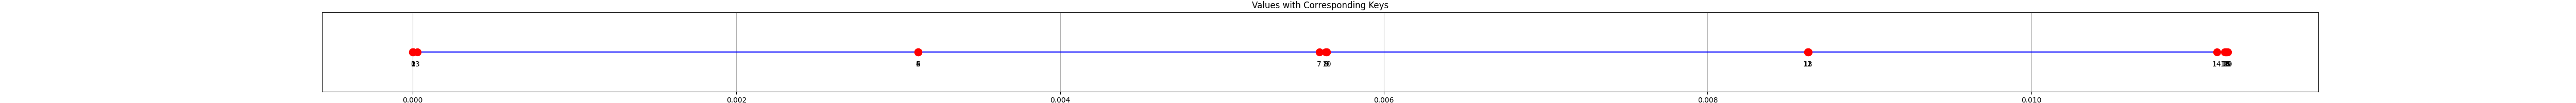

In [69]:
%matplotlib widget

timestamps_head = [col for col in list(df.columns.values) if 'timestamp' in col]
data = df[timestamps_head][::1].to_dict(orient='records')[0]


# Filter out NaN values
data = {key: value for key, value in data.items() if not str(value).lower() == 'nan'}
data = dict(sorted(data.items(), key=lambda item: item[1]))

# Extract keys and values
keys = list(data.keys())
key_indices = [i for i in range(0, len(keys))]
values = [value - min(data.values()) for value in data.values()]

## Create a horizontal line plot with different markers and labels at the bottom
fig, ax = plt.subplots(figsize=(50, 2))
ax.hlines(y=0, xmin=min(values), xmax=max(values), colors='b')
for key, value in zip(key_indices, values):
    ax.plot(value, 0, 'ro', markersize=10)  # Use red circle marker
    ax.annotate(f'{key}', (value, -0.02), ha='center')

# Set axis labels, hide the y-axis, and display the plot
ax.set_xlabel('Values')
ax.set_yticks([])  # Hide the y-axis
ax.set_title('Values with Corresponding Keys')
ax.grid()
plt.savefig('journey.png')
plt.show()

In [64]:
print({i:keys[i] for i in key_indices})
print({i:values[i] for i in key_indices})
print(len(key_indices))

{0: 'ip.in.timestamp', 1: 'pdcp.cipher.timestamp', 2: 'pdcp.pdu.timestamp', 3: 'rlc.queue.timestamp', 4: 'rlc.queue.segments.0.rlc.txpdu.timestamp', 5: 'rlc.queue.segments.0.mac.sdu.timestamp', 6: 'rlc.queue.segments.0.mac.harq.timestamp', 7: 'rlc.reassembled.1.mac.demuxed.mac.decoded.0.timestamp', 8: 'rlc.reassembled.1.mac.demuxed.timestamp', 9: 'rlc.reassembled.1.rlc.decoded.timestamp', 10: 'rlc.reassembled.1.rlc.reassembled.timestamp', 11: 'rlc.queue.segments.1.rlc.txpdu.timestamp', 12: 'rlc.queue.segments.1.mac.sdu.timestamp', 13: 'rlc.queue.segments.1.mac.harq.timestamp', 14: 'rlc.reassembled.0.mac.demuxed.mac.decoded.0.timestamp', 15: 'rlc.reassembled.0.mac.demuxed.timestamp', 16: 'rlc.reassembled.0.rlc.decoded.timestamp', 17: 'rlc.reassembled.0.rlc.reassembled.timestamp', 18: 'pdcp.decoded.timestamp', 19: 'sdap.sdu.timestamp', 20: 'gtp.out.timestamp'}
{0: 0.0, 1: 9.5367431640625e-07, 2: 3.0994415283203125e-06, 3: 2.9087066650390625e-05, 4: 0.003122091293334961, 5: 0.003122091293